In [1]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
np.random.seed(1337)
random.seed(1337)


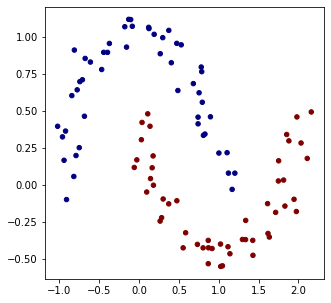

In [4]:


# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')



In [120]:
class NewMLP(MLP):

    def layer_parameters(self):
        params = []
        for layer in self.layers:
            ar = []
            for p in layer.parameters():
                ar.append(p)
            params.append(ar)
        return params


In [121]:
# initialize a model 
model = NewMLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [122]:
for idx,layer in enumerate(model.layers):
    arr = []
    for neuron in layer.neurons: 
        _arr = []
        for wt in neuron.w:
            _arr.append(wt.data)
        arr.append(_arr)    
    arr = np.array(arr)
    print(arr.mean(),arr.std(),idx)

0.18651074700472142 0.5313235780721669 0
0.024362634073518456 0.5687503096111773 1
0.14404791979613757 0.5492214506147415 2


In [123]:
#After Training. 
for idx,layer in enumerate(model.layers):
    arr = []
    for neuron in layer.neurons: 
        _arr = []
        for wt in neuron.w:
            _arr.append(wt.data)
        arr.append(_arr)    
    arr = np.array(arr)
    print(arr.mean(),arr.std(),idx)

0.18651074700472142 0.5313235780721669 0
0.024362634073518456 0.5687503096111773 1
0.14404791979613757 0.5492214506147415 2


In [124]:
import numpy as np 


In [125]:
X[0,:]

array([1.12211461, 0.08147717])

In [126]:
_x = X[:10]
_y = y[:10]
inputs = [list(map(Value, xrow)) for xrow in _x]
scores = list(map(model, inputs))

In [127]:
sdf = pd.DataFrame({'x':_x[:,0],'y':_x[:,1],'target':_y,'score':scores})
sdf['svm_loss'] = sdf.apply(lambda x: (1 + -x.target*x.score),axis=1)

In [128]:
sdf

,x,y,target,score,svm_loss
0,1.122115,0.081477,-1,"Value(data=0.9570002719439219, grad=0)","Value(data=1.957000271943922, grad=0)"
1,-0.818829,0.058790,-1,"Value(data=0.6093073964792304, grad=0)","Value(data=1.6093073964792304, grad=0)"
2,1.613710,-0.124646,1,"Value(data=1.4262713163497758, grad=0)","Value(data=-0.4262713163497758, grad=0)"
3,-0.923009,0.365229,-1,"Value(data=0.7778523154358785, grad=0)","Value(data=1.7778523154358785, grad=0)"
4,0.143851,0.044380,1,"Value(data=0.11482048025871873, grad=0)","Value(data=0.8851795197412813, grad=0)"
5,0.164472,0.117383,1,"Value(data=0.09672433843733749, grad=0)","Value(data=0.9032756615626625, grad=0)"
6,1.338771,-0.238010,1,"Value(data=1.2372150855129775, grad=0)","Value(data=-0.23721508551297754, grad=0)"
7,0.871149,-0.422718,1,"Value(data=0.6183959661718244, grad=0)","Value(data=0.38160403382817565, grad=0)"
8,1.831299,-0.141044,1,"Value(data=1.6185015336904618, grad=0)","Value(data=-0.6185015336904618, grad=0)"
9,0.487571,0.639093,-1,"Value(data=0.21297165469616358, grad=0)","Value(data=1.2129716546961635, grad=0)"


In [129]:
# loss function
def loss():
    
    Xb, yb = X, y
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)



Value(data=0.9702328530504141, grad=0) 0.5


In [130]:
# optimization
stats_arr = []
for k in range(34):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for idx,layer in enumerate(model.layer_parameters()):
        layer_p = []
        layer_grad = []
        for p in layer:
            layer_p.append(p.data)
            layer_grad.append(p.grad)
            p.data -= learning_rate * p.grad
        
        stats_arr.append({
            "epoch":k,
            "layer":idx,
            "layer_mean":np.array(layer_p).mean(),
            "grad":np.array(layer_grad).mean()
        })
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.9702328530504141, accuracy 50.0%
step 1 loss 1.3447972582142753, accuracy 56.99999999999999%
step 2 loss 2.0371433469680387, accuracy 53.0%
step 3 loss 0.4527405949624517, accuracy 84.0%
step 4 loss 0.48977080936766293, accuracy 84.0%
step 5 loss 0.3177869795857168, accuracy 87.0%
step 6 loss 0.297265056820265, accuracy 87.0%
step 7 loss 0.29476785020867335, accuracy 87.0%
step 8 loss 0.3144235674840439, accuracy 86.0%
step 9 loss 0.2948239457461288, accuracy 89.0%
step 10 loss 0.30076464578086964, accuracy 86.0%
step 11 loss 0.27232875027888925, accuracy 90.0%
step 12 loss 0.27539993394477663, accuracy 86.0%
step 13 loss 0.26562388865454084, accuracy 90.0%
step 14 loss 0.2677862283453269, accuracy 89.0%
step 15 loss 0.24372186558228146, accuracy 92.0%
step 16 loss 0.2447080839578291, accuracy 91.0%
step 17 loss 0.2138226595819824, accuracy 94.0%
step 18 loss 0.21749835933992284, accuracy 90.0%
step 19 loss 0.19711172430038124, accuracy 95.0%
step 20 loss 0.19553723698389

KeyboardInterrupt: 

(-1.548639298268643, 1.951360701731357)

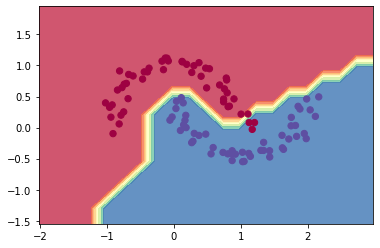

In [144]:


# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())



In [149]:
Z.shape,xx.shape,np.array([s.data > 0 for s in scores]).shape,X.shape

((15, 21), (15, 21), (315,), (100, 2))

In [139]:
import pandas as pd
df = pd.DataFrame(stats_arr)

In [140]:
df.sample(10)

,epoch,layer,layer_mean,grad
75,25,0,-0.028761,-0.000167
21,7,0,-0.024815,-0.002272
65,21,2,0.159075,0.029648
97,32,1,-0.010884,0.000944
54,18,0,-0.029300,0.003739
98,32,2,0.180755,0.014848
15,5,0,-0.023551,0.000344
19,6,1,-0.011844,-0.000458
17,5,2,0.102578,-0.006895
25,8,1,-0.011475,-0.000754


In [141]:
df['grad_layer_pct'] = df.apply(lambda x: abs((x.grad*100)/x.layer_mean),axis=1)

In [143]:
df.loc[df.layer == 2]

,epoch,layer,layer_mean,grad,grad_layer_pct
2,0,2,0.135575,0.120921,89.191700
5,1,2,0.014653,-0.243392,1661.004070
8,2,2,0.255855,0.206065,80.539871
11,3,2,0.053499,-0.091455,170.947155
14,4,2,0.142484,0.041397,29.053418
17,5,2,0.102578,-0.006895,6.721728
20,6,2,0.109163,-0.008027,7.353158
23,7,2,0.116756,0.016228,13.899462
26,8,2,0.101550,-0.022655,22.309304
29,9,2,0.122574,0.022261,18.161477
